# 12.01. 실제 예측 문제

In [2]:
library(patchwork)
library(tidyverse)
library(fpp3)
library(fpp2)
library(fpp)
library(forecast)

<br>

## 12.01. 주별, 일별, 그리고 일별 이하의 데이터

주별, 일별, 그리고 일별 이하의 데이터는 여러 가지 다른 이유로 예측하기 어려울 수 있습니다.


<br>

### 주별 데이터

주별 데이터는 계절성 주기(1년 전체 주의 개수)가 크면서 정수가 아니라서 어렵습니다. 1년에 있는 주의 평균 개수는 52.18입니다. 이 책에서 다룬 대부분의 기법에서 계절성은 정수이어야 합니다. 1년에 있는 주의 개수를 근사적으로 52로 두어도, 대부분의 기법은 이렇게 큰 계절성 주기를 효과적으로 다루지 못할 것입니다.

**가장 간단한 접근 방식은 (6 장에서 다룬 것처럼) 계절성으로 조정된 데이터에 적용한 비-계절성 기법으로 STL 분해를 이용하는 것입니다.** 여기에서는 한 예제로 1991년 2월부터 2005년 5월까지 미국 완성차에 사용하는 용도의 휘발유 제품의 주별 데이터를 (단위: 백만 배럴/일) 다루겠습니다.

* 계절성으로 조정된 데이터에 대한 ETS 모델과 STL 분해를 이용하여 주별 미국 휘발유 생산 예측값.

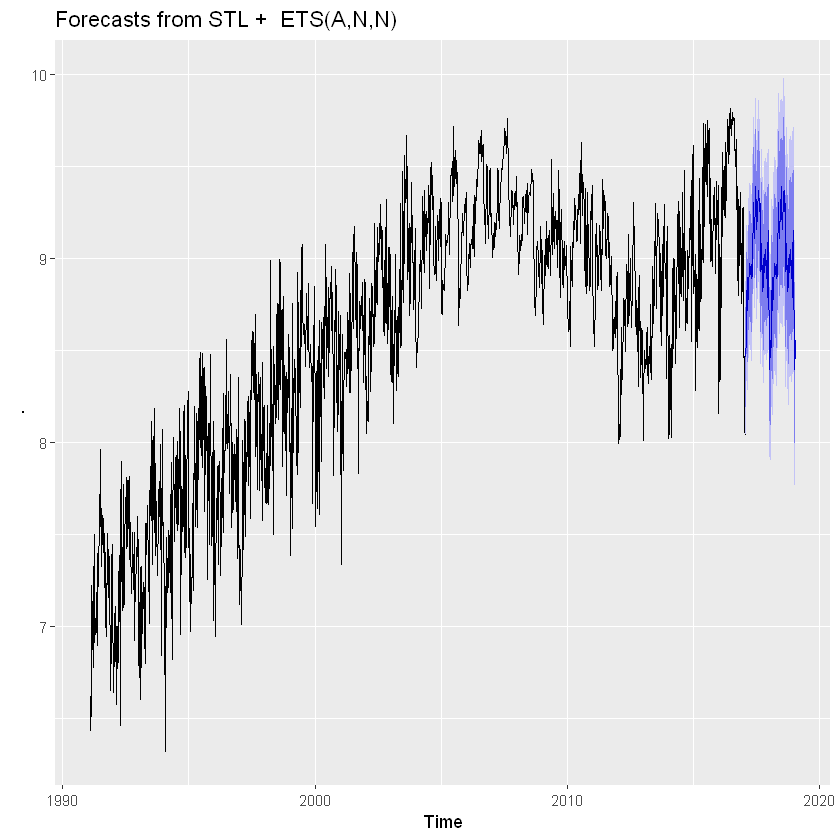

In [4]:
gasoline %>% stlf() %>% autoplot()

**다른 접근 방식으로는 9.5 절에서 다룬 동적 조화 회귀(dynamic harmonic regression) 모델을 사용하는 것이 있습니다. 다음의 예제에서는, AICc 를 최소화하여 푸리에 항의 수를 고릅니다. `auto.arima()` 함수 안에서 해주긴 하지만, ARIMA 모델의 차수 역시 AICc 를 최소화하여 고릅니다.**



In [5]:
bestfit <- list(aicc=Inf)

for(K in seq(25)) {
  fit <- auto.arima(gasoline, xreg=fourier(gasoline, K=K),
    seasonal=FALSE)
  if(fit[["aicc"]] < bestfit[["aicc"]]) {
    bestfit <- fit
    bestK <- K
  }
}

* 동적 조화 회귀 모델을 이용하여 얻은 매주 미국 휘발유 생산 예측값.

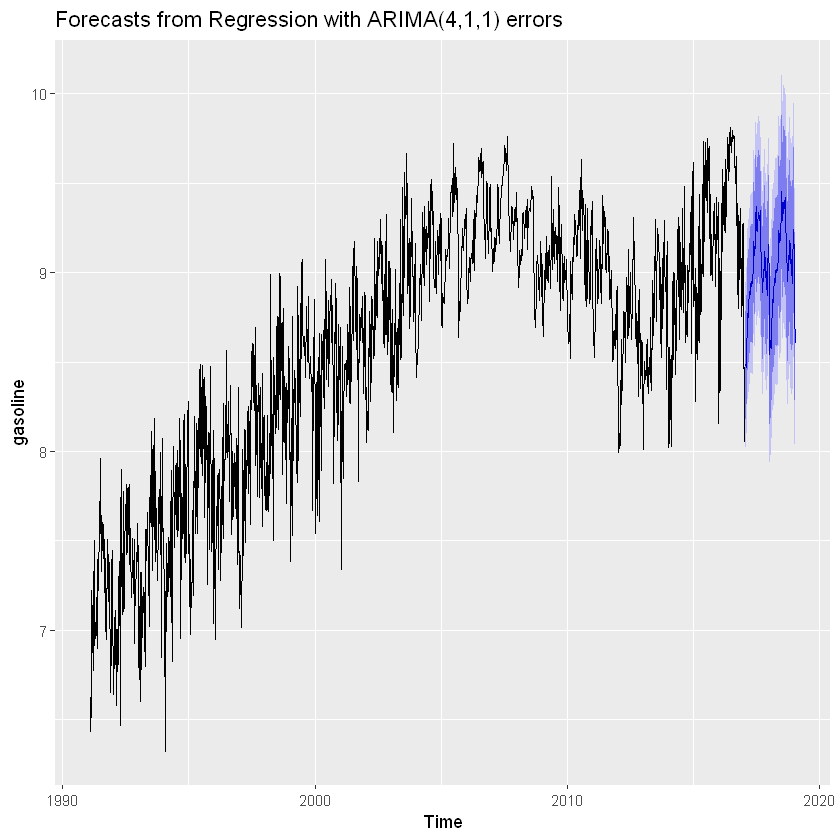

In [6]:
fc <- forecast(bestfit,
  xreg=fourier(gasoline, K=bestK, h=104))

autoplot(fc)

적합 모델(fitted model)에는 푸리에 항(Fourier term)의 18개의 쌍이 있고 다음과 같이 쓸 수 있습니다.

$$y_t = bt + \sum_{j=1}^{18} \left[ \alpha_j\sin\left(\frac{2\pi j t}{52.18}\right) + \beta_j\cos\left(\frac{2\pi j t}{52.18}\right) \right] + \eta_t$$ 

여기에서  $
η_
t$
 는 ARIMA(4,1,1) 과정입니다.  $
n_
t$
 가 정상성(stationarity)을 나타내지 않기 때문에, 실제로 이 모델은 이 식의 양 변에 있는 변수의 차분값(difference)에 대해 추정된 것입니다. 꽤 크지만 AICc 선택에 따르면 분명히 필요한 계절성을 잡아내기 위한 36개의 매개변수가 있습니다. 전체 자유도 개수는 42입니다(다른 6개는 4개의 자기회귀 매개변수, 1개의 이동평균 매개변수와 표류 매개변수에서 왔습니다).

**또 다른 접근 방법은 11.1에서 소개한 TBATS 모델입니다. 계절성이 시간에 따라 변할 때는 TBATS 모델이 좋습니다. ARIMA 접근 방식은 추가적인 회귀자(regressor)로 넣을 수 있는 유용한 예측변수(predictor variable)인 공변량(covariate)이 있을 때 좋습니다.**

<br>

### 일별과 일별 이하의 데이터

일별과 일별 이하의 데이터는 다른 이유에서 어렵습니다. 여기에는 종종 여러 계절성 패턴이 들어가서 이러한 복잡한 계절성을 다룰 기법을 사용해야 하기 때문입니다.

물론, 시계열이 상대적으로 짧아서 계절성이 단 하나만 나타나는 경우에는, 우리가 다룬 (예를 들어, ETS나 계절성 ARIMA) 단일-계절성 기법 중에서 하나를 사용할 수 있을 것입니다. 하지만, 계절성이 충분히 길어서 더 긴 몇몇 계절성 주기가 분명해지면, 동적 조화 회귀(dynamic harmonic regression)나 11.1에서 다룬 TBATS를 사용할 필요가 있을 것입니다.

하지만, 이러한 모델도 규칙적인 계절성만 허용한다는 것을 기억해야 합니다. 부활절, 이드(이슬람교의 두 가지 주요 축제인 Eid ul-Fitr나 Eid ul-Adha), 중국의 새해 첫 날은 같이 바뀌는 사건과 관련된 계절성을 잡아내는 것은 더 어렵습니다. 월별 데이터에서도, (부활절의 경우) 3월이나 4월에, (중국의 새해 첫 날의 경우) 1월이나 2월에, (이드의 경우) 1년의 어떤 시기가 될 수 있기 떄문에 어려울 수 있습니다.

바뀌는 휴일 효과를 다루는 가장 좋은 방법은 가변수(dummy variable)를 사용하는 것입니다. 하지만, ETS나 TBATS 둘 다 공변량(covariate)을 허용하지 않습니다. 이 책에서 다룬 모델 중에서 (그리고 R의 forecast 패키지에 구현된), 유일한 선택지는 동적 조화 회귀(dynamic harmonic regression)입니다. 여기에서 예측변수(predictor variable)는 어떠한 모의 휴일 효과도 넣을 수 있습니다(그리고 푸리에 항을 이용하는 계절성도 넣을 수 있을 것입니다).

<br>

## 12.02. 개수를 세서 만든 시계열

이 책에서 다룬 모든 기법은 데이터가 연속적인 표본 공간을 갖는다고 가정합니다. 하지만 개수를 센 형태의 데이터를 꽤 자주 만날 수 있습니다. 예를 들면, 매일 어떤 상점에 들어온 손님 수를 예측하고 싶을 수 있습니다. 이 경우에 0, 1, 2, , 명과 같이 손님을 셀 것입니다. 하지만 3.45693 명의 손님이 오는 경우는 없습니다.

실제 상황에서, 개수가 충분하게 크면 이러한 값이 별로 문제가 되지 않습니다. 손님의 최소 수가 적어도 100명이라면, 예측값을 구할 때 연속적인 표본 공간  $
[
100
,
∞
)$
 과 이산적인(discrete) 표본 공간  $
\{
100
,
101
,
102
,
…
\}$
  사이에 눈에 띄는 차이가 생기지 않습니다. 하지만,  $
(
0
,
1
,
2
,
…
)$
 처럼 개수가 작은 경우에는, 음이 아닌 정수 표본 공간에 대해 더욱 적절한 예측 기법을 사용해야 합니다.

이러한 모델은 이 책의 범위를 벗어납니다. 하지만, 이 책의 맥락 안에서 소개할 만한 한 가지 간단한 기법이 있습니다. Croston (1972) 에서 처음 언급되었고 영국 발명가 존 크로스턴(John Croston)의 이름을 따서 지은 크로스턴(Croston) 기법이 있습니다. 사실 이 기법은 개수를 세서 만든 데이터의 특징을 적절하게 다루지는 못합니다만, 자주 사용되고 있고, 알아둘 만합니다.

크로스턴(Croston) 기법으로 원본 시계열을 가지고, 시간 범위 안에 0 값을 포함하는 시계열과 시간 범위 안에 0이 없는 시계열 이렇게 2개의 새로운 시계열을 구성합니다. 0이 아닌  $
i$
 번째 값을  $
q_
i$
 이라고 두고,  $
q_{
i
−
1}$
 와  $
q_
i$
  사이 시간을  $
a_
i$
 라고 둡시다. 크로스턴(Croston) 기법에는 2개의 새로운 시계열  $
a$
 와$  
q$
 에 대한 단순 지수 평활(simple exponential smoothing) 예측값이 들어갑니다. 왜냐하면 이 기법은 상품에 대한 수요값으로 구성되는 시계열에 적용되기 때문이고,  $
q$
 는 종종 “수요(demand)”라고 부르고  $
a$
 는 “도착 간격 시간(inter-arrival time)”이라고 부릅니다.

$\hat{q}_{i+1|i}$, $\hat{a}_{i+1|i}$ 번째 수요와 도착 간격 시간에 대해 수요  $
i$
 까지의 데이터에 기초하여 낸 한 단계 예측값입니다. 그러면 크로스턴(Croston) 기법에서 다음과 같은 관계식을 얻을 수 있습니다.

$$\begin{align}
  \hat{q}_{i+1|i} & = (1-\alpha)\hat{q}_{i|i-1} + \alpha q_i, \\
  \hat{a}_{i+1|i} & = (1-\alpha)\hat{a}_{i|i-1} + \alpha a_i. 
\end{align}$$

평활 매개변수(smoothing parameter)  $
α$
 는 0과 1사이의 값을 갖고, 두 식에 대해 같다고 가정합니다.$  
j$
 를 마지막 양(+)의 관측값에 대한 시간이라고 둡시다. 그러면 시간  $
T
+
h$
 에서 수요에 대한  $
h$
  단계 앞 예측값은 다음과 같은 비율로 주어집니다.

$$\begin{equation}\label{c2ratio}
  \hat{y}_{T+h|T} = q_{j+1|j}/a_{j+1|j}.
\end{equation}$$

이 기법이 어떠한 통계적인 모델과도 관련이 없기 때문에 (Shenstone & Hyndman, 2005) 이 경우에는 예측 구간을 대수적으로 계산할 수 있는 방법이 없습니다.

`croston()` 함수는 크로스턴(Croston) 기법을 이용하여 예측값을 냅니다.

이 함수는 기본값으로  $
α
=
0.1$
 을 이용하고,  $
ℓ_
0$
 은 각 시계열의 첫 번째 관측값과 같게 둡니다. 이렇게 두는 것은 크로스턴(Croston)이 기법을 생각해낸 방식과 일맥상통합니다.

<br>

### 예제: 윤활유 판매

몇 년 전에, 원유 회사의 월별 윤활유 판매량을 예측하는 일을 도왔습니다. 아래 표는 사용했던 시계열 중에서 하나를 나타냅니다.

데이터에 작은 수의 개수값이 있습니다. 어떤 달에는 전혀 팔리지 않기도 하고 다른 달에는 적은 수의 상품만 팔렸습니다.

<table>
<thead>
<tr>
<th style="text-align:right;">
Year
</th>
<th style="text-align:right;">
Jan
</th>
<th style="text-align:right;">
Feb
</th>
<th style="text-align:right;">
Mar
</th>
<th style="text-align:right;">
Apr
</th>
<th style="text-align:right;">
May
</th>
<th style="text-align:right;">
Jun
</th>
<th style="text-align:right;">
Jul
</th>
<th style="text-align:right;">
Aug
</th>
<th style="text-align:right;">
Sep
</th>
<th style="text-align:right;">
Oct
</th>
<th style="text-align:right;">
Nov
</th>
<th style="text-align:right;">
Dec
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
11
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
0
</td>
</tr>
<tr>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
6
</td>
<td style="text-align:right;">
3
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
7
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
</tr>
<tr>
<td style="text-align:right;">
3
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
3
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
</tr>
</tbody>
</table>

시계열에서 0이 아닌 수요 값 11개가 있습니다. 이것을 $q$로 적습니다. 수요에 대응하기 위해 공급하려는 시계열 $a$를 다음의 표에서 확인할 수 있습니다.

<table>
<tbody>
<tr>
<td style="text-align:left;">
<span class="math inline">\(i\)</span>
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
3
</td>
<td style="text-align:right;">
4
</td>
<td style="text-align:right;">
5
</td>
<td style="text-align:right;">
6
</td>
<td style="text-align:right;">
7
</td>
<td style="text-align:right;">
8
</td>
<td style="text-align:right;">
9
</td>
<td style="text-align:right;">
10
</td>
<td style="text-align:right;">
11
</td>
</tr>
<tr>
<td style="text-align:left;">
<span class="math inline">\(q\)</span>
</td>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
11
</td>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
6
</td>
<td style="text-align:right;">
3
</td>
<td style="text-align:right;">
7
</td>
<td style="text-align:right;">
3
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
1
</td>
</tr>
<tr>
<td style="text-align:left;">
<span class="math inline">\(a\)</span>
</td>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
5
</td>
<td style="text-align:right;">
2
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
6
</td>
<td style="text-align:right;">
8
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
3
</td>
<td style="text-align:right;">
2
</td>
</tr>
</tbody>
</table>

크로스턴(Croston) 기법을 적용하여 수요 예측값 2.750과 도착 간격 시간 예측값 2.793을 얻습니다. 그래서 원본 시계열의 예측값은 $\hat{y}_{T+h|T} = 2.750 / 2.793 = 0.985$가 됩니다. 실제로는 이러한 계산을 R에서 다음과 같이 하면 됩니다:



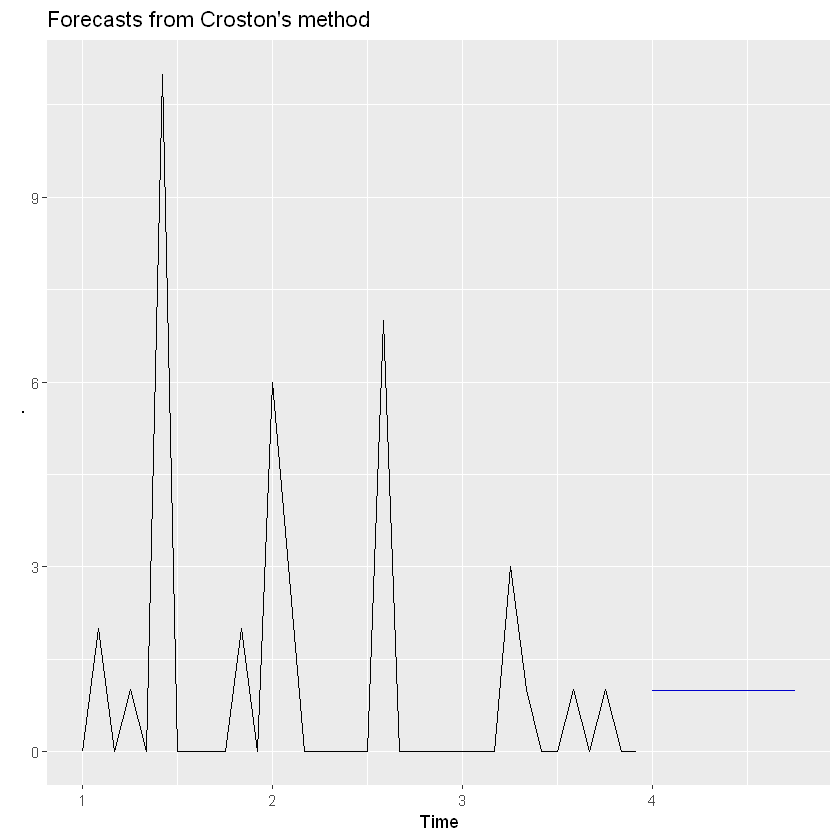

In [7]:
productC %>% croston() %>% autoplot()

매개변수 추정을 포함하여 여러 기능과 함께 크로스턴(Croston) 기법을 구현한 것은 R의 `tsintermittent` 패키지에서 이용할 수 있습니다.

데이터의 개수값 특성을 다루는 예측 모델은 Christou & Fokianos (2015) 에서 설명합니다.

<br>

## 12.03. 예측값이 반드시 범위 안에 있도록 만들기

예측값이 양수값이길 바라는 것이나 어떤 특정한 범위 $[a,b]$ 안에 있도록 하는 것은 흔한 일입니다. 변환을 이용하면 이러한 상황 둘 다 상대적으로 쉽게 다룰 수 있습니다.

<br>

### 양수 예측값

양수 제한 조건을 걸려면, 단순히 박스-칵스(Box-Cox) 변환 매개변수를  $\lambda=0$로 두고 로그 눈금에서 작업하면 됩니다. 예를 들어, 계란 12개의 실제 가격(1900년부터 1993년까지; 단위: 센트)을 다뤄보면:



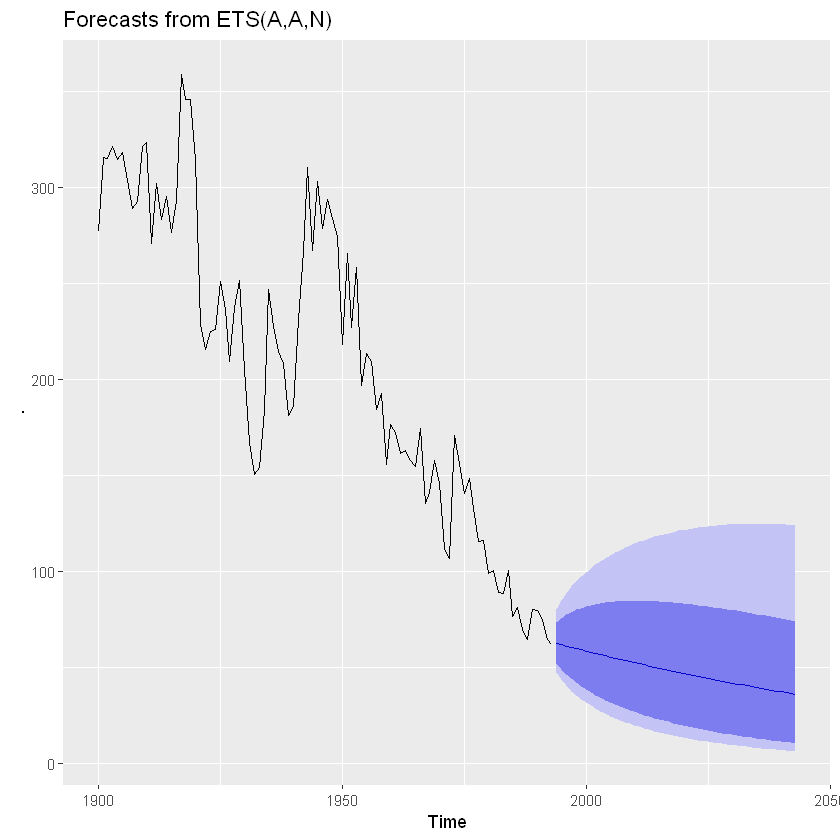

In [8]:
eggs %>%
  ets(model="AAN", damped=FALSE, lambda=0) %>%
  forecast(h=50, biasadj=TRUE) %>%
  autoplot()

`biasadj=TRUE`로 두었기 때문에, 예측값은 예측 분포의 평균값입니다.

<br>

### 어떤 범위 안에 제한된 예측값

어떤 범위 안에 제한된 데이터를 다루는 방법을 살펴보기 위해, 계란 가격이  $a=50$에서, $b=400$ 사이에 있었다고 생각해봅시다. 그러면, $(a,b)$를 전체 실수(real) 선으로 눈금 조절된 로짓(logit) 변환으로 데이터를 변환할 수 있습니다:

$$y = \log\left(\frac{x-a}{b-x}\right),$$


여기에서  $
x$
 는 원래의 눈금에 있는 값이고, $ 
y$
 는 변환된 데이터입니다. 변환을 되돌리려면, 다음의 관계식을 사용하면 됩니다.

$$x  = \frac{(b-a)e^y}{1+e^y} + a.$$

이것은 내장된 변환이 아니기 때문에, 추가적인 작업이 필요합니다.



<br>

* 50과 400 사이에 오도록 제한을 둔 상황에서 계란 12개 가격 예측값.

In [9]:
# Bounds
a <- 50
b <- 400

In [11]:
# Transform data and fit model
fit <- log((eggs-a)/(b-eggs)) %>%
  ets(model="AAN", damped=FALSE)

fc <- forecast(fit, h=50)

In [12]:
# Back-transform forecasts
fc[["mean"]] <- (b-a)*exp(fc[["mean"]]) /
  (1+exp(fc[["mean"]])) + a

fc[["lower"]] <- (b-a)*exp(fc[["lower"]]) /
  (1+exp(fc[["lower"]])) + a

fc[["upper"]] <- (b-a)*exp(fc[["upper"]]) /
  (1+exp(fc[["upper"]])) + a

fc[["x"]] <- eggs

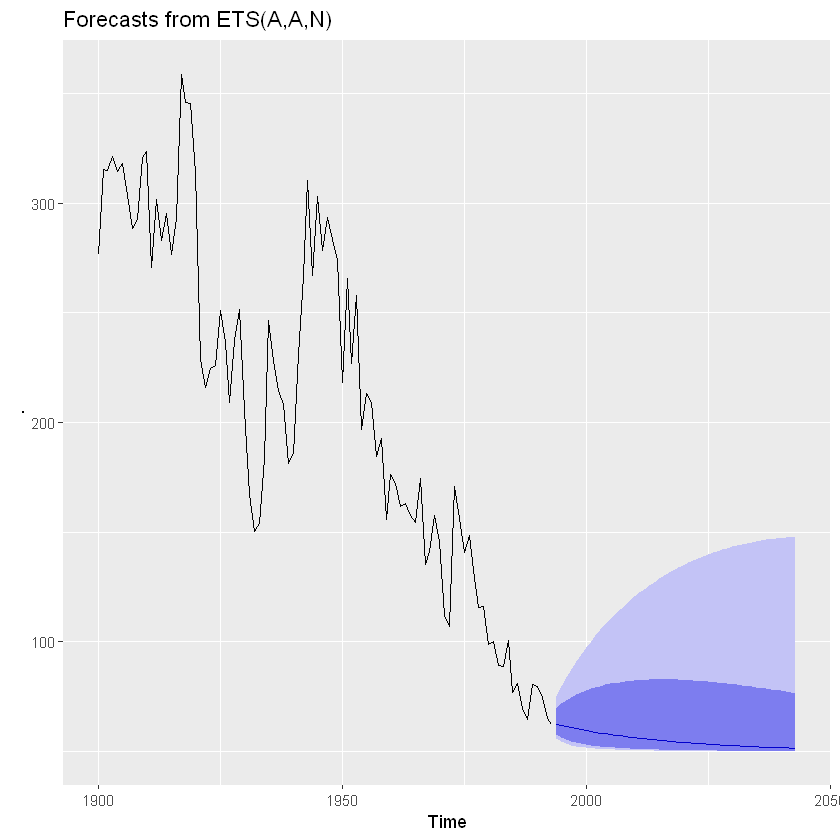

In [13]:
autoplot(fc)

여기에서 편향 조정을 사용하지 않았습니다. 그래서 예측값은 미래 분포의 중간값입니다. 이러한 변환에서 얻은 예측 구간은 단조 증가 변환(monotonically increasing transformation)에도 분위수(quantile)가 보존되기 때문에 변환된 눈금에서 얻은 것과 같은 포함확률(coverage probability)을 갖습니다.

예측구간은 변환 때문에 50 이상에 위치합니다. 이러한 인위적인 (그리고 비현실적인) 제한 조건의 결과로, 예측분포는 극단적으로 쏠리게 됩니다.



<br>

## 12.04. 예측조합

예측 정확도를 쉽게 높이는 방법은 같은 시계열에 몇 가지 서로 다른 기법을 적용하여, 결과 예측값을 평균하는 것입니다. 거의 50년 전에, 존 베이츠(John Bates)와 클리브 그랭거(Clive Granger)가 유명한 논문(Bates & Granger, 1969)을 썼는데, 여기에서 예측값을 조합하면 종종 더 나은 예측 정확도로 이어진다는 것을 보였습니다. 20년 후에, Clemen (1989) 에서 다음과 같이 이야기 했습니다.


```
결과는 사실상 만장일치가 된다: 여러 예측값을 조합하는 것은 예측 정확도 증가로 이어진다. 많은 경우에 단순히 예측값의 평균을 구하는 것만으로도 극적인 성능 증가를 만들 수 있다.


```

가중 평균을 사용하는 것이나 더 복잡하게 조합하는 몇몇 접근 방법에 관한 중요한 연구가 있지만, 단순한 평균을 사용하는 것을 압도할 정도로 뛰어나지는 않다는 것이 알려져 있습니다.

1982년 4월부터 2017년 9월까지 호주 월별 외식 지출 데이터를 이용한 예제를 살펴보겠습니다. 여기에서 다음과 같은 모델을 사용하겠습니다: ETS, ARIMA, STL-ETS, NNAR, 그리고 TBATS. 그런 다음, 마지막 5년(60개월) 관측값을 가지고 결과를 비교하겠습니다.

In [14]:
train <- window(auscafe, end=c(2012,9))
h <- length(auscafe) - length(train)

In [15]:
ETS <- forecast(ets(train), h=h)
ARIMA <- forecast(auto.arima(train, lambda=0, biasadj=TRUE),
  h=h)
STL <- stlf(train, lambda=0, h=h, biasadj=TRUE)
NNAR <- forecast(nnetar(train), h=h)
TBATS <- forecast(tbats(train, biasadj=TRUE), h=h)
Combination <- (ETS[["mean"]] + ARIMA[["mean"]] +
  STL[["mean"]] + NNAR[["mean"]] + TBATS[["mean"]])/5

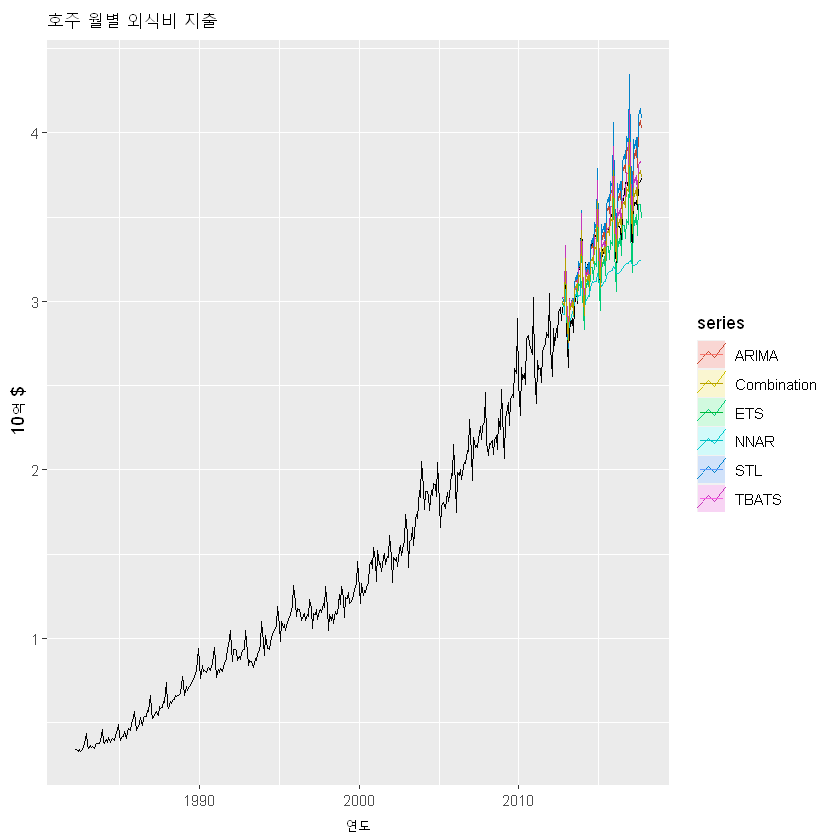

In [16]:
autoplot(auscafe) +
  autolayer(ETS, series="ETS", PI=FALSE) +
  autolayer(ARIMA, series="ARIMA", PI=FALSE) +
  autolayer(STL, series="STL", PI=FALSE) +
  autolayer(NNAR, series="NNAR", PI=FALSE) +
  autolayer(TBATS, series="TBATS", PI=FALSE) +
  autolayer(Combination, series="Combination") +
  xlab("연도") + ylab("10억 $") +
  ggtitle("호주 월별 외식비 지출")

In [17]:
c(ETS = accuracy(ETS, auscafe)["Test set","RMSE"],
  ARIMA = accuracy(ARIMA, auscafe)["Test set","RMSE"],
  `STL-ETS` = accuracy(STL, auscafe)["Test set","RMSE"],
  NNAR = accuracy(NNAR, auscafe)["Test set","RMSE"],
  TBATS = accuracy(TBATS, auscafe)["Test set","RMSE"],
  Combination =
    accuracy(Combination, auscafe)["Test set","RMSE"])

ETS       ARIMA     STL-ETS        NNAR       TBATS Combination 
 0.13699696  0.15919858  0.19310148  0.29902293  0.09406039  0.07136182

TBATS가 이 시계열에서 특별히 성능이 좋은 것으로 나타나지만, 조합 접근 방식이 훨씬 더 낫습니다. 다른 데이터에서, TBATS는 꽤 안 좋은 것 같지만, 조합 접근 방식이 거의 항상 가장 좋은 기법에 가깝거나 더 좋은 것으로 나타납니다.

<br>

## 12.05. 합산 값에 대한 예측 구간

분배한 데이터(disaggregated data)에 적합모델(fitted model)로 데이터의 몇몇 시기의 합산값을 예측하는 것은 흔히 접하게 되는 문제입니다. 예를 들면, 월별 데이터를 가지고 있을 수 있는데, 내년 전체를 예측하고 싶을 수 있기 때문입니다. 또는, 주별 데이터를 가지고 있을 수 있는데, 다음 4주에 전체값을 예측하고 싶을 수 있습니다.

점 예측값이 평균값일 때는, 이 값을 더하면 원하는 전체값에 대한 좋은 추정값이 될 수 있습니다. 하지만, 예측구간은 예측오차 사이의 상관관계 때문에 더 어렵습니다.

일반적인 해결책은 모사(simulation)하는 것입니다. ETS 모델을 호주 월별 가스 생산 데이터에 적용한 예제로 살펴보겠습니다. 다음 6개월 가스 수요의 합산값을 예측하고 싶다고 가정해보겠습니다.



In [18]:
# First fit a model to the data
fit <- ets(gas/1000)

In [19]:
# Forecast six months ahead
fc <- forecast(fit, h=6)

In [20]:
# Simulate 10000 future sample paths
nsim <- 10000
h <- 6
sim <- numeric(nsim)

In [21]:
for(i in seq_len(nsim))
  sim[i] <- sum(simulate(fit, future=TRUE, nsim=h))

meanagg <- mean(sim)

모사한(simulated) 상황의 평균이 각 예측값의 합과 비슷합니다:

In [22]:
sum(fc[["mean"]][1:6])

[1] 281.8006

In [23]:
meanagg

[1] 281.7655

예측 구간도 쉽게 얻을 수 있습니다:

In [24]:
quantile(sim, prob=c(0.1, 0.9))

10%      90% 
263.1409 301.0603

In [25]:
quantile(sim, prob=c(0.025, 0.975))

2.5%    97.5% 
254.1134 311.4520

<br>

## 12.06. 과거 재구성

때때로 시계열을 반대로 “재구성(backcast)”하는 것이 유용합니다 — 즉, 시간이 흐르는 반대 방향으로 예측하는 것입니다. 이 작업을 해주는 내장된 R 함수가 있지는 않지만, 쉽게 구현할 수 있습니다. 다음의 함수로 ts 객체와 `forecast` 객체를 뒤집을 수 있습니다.

In [26]:
# Function to reverse time
reverse_ts <- function(y) {
  ts(rev(y), start=tsp(y)[1L], frequency=frequency(y))
}

In [27]:
# Function to reverse a forecast

reverse_forecast <- function(object) {
  h <- length(object[["mean"]])
  f <- frequency(object[["mean"]])
  object[["x"]] <- reverse_ts(object[["x"]])
  object[["mean"]] <- ts(rev(object[["mean"]]),
                    end=tsp(object[["x"]])[1L]-1/f, frequency=f)
  object[["lower"]] <- object[["lower"]][h:1L,]
  object[["upper"]] <- object[["upper"]][h:1L,]
    
  return(object)
}

그리고 나서 어떤 시계열을 재구성하기 위해 이러한 함수를 적용할 수 있습니다. 1996년부터 2011년까지 유로존에서의 분기별 소매업 데이터에 적용한 예제를 살펴보겠습니다. 1994년부터 1995년을 재구성해보겠습니다.

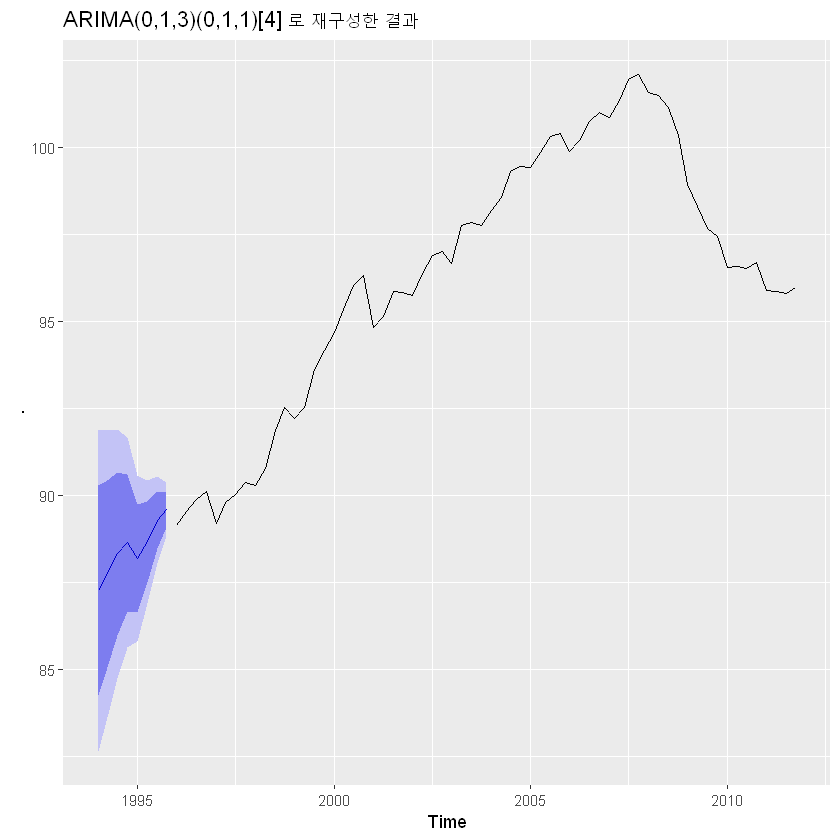

In [28]:
# Backcast example
euretail %>%
  reverse_ts() %>%
  auto.arima() %>%
  forecast() %>%
  reverse_forecast() -> bc

autoplot(bc) +
  ggtitle(paste(bc[["method"]], "로 재구성한 결과"))

<br>

## 12.07. 아주 긴 시계열과 아주 짧은 시계열

<br>

### 아주 짧은 시계열을 예측하기

데이터가 거의 없을 때 시계열 모델을 어떻게 맞출 수 있는지 종종 질문 받습니다. 거의 모든 표본 크기의 질문처럼, 쉬운 답변은 없습니다. 데이터에 있는 무작위성의 정도와 모델에서 추정해야 할 매개변수(parameter) 수에 따라 다릅니다. 필요한 표본 크기는 추정해야 할 매개변수의 수에 따라 그리고 데이터에서 나타나는 잡음의 양에 따라 늘어납니다.

몇몇 교과서에서는 주먹구구식으로 다양한 시계열 모델에 대한 최소 표본 크기를 이야기합니다. 이러한 숫자는 오해의 소지가 있고 이론적으로나 실제적으로 입증된 바가 없습니다. 게다가, 이런 것은 데이터의 근본적인 가변성(underlying variability)을 무시하고 추정해야 할 매개변수의 수 역시 간과합니다. 예를 들어, ARIMA 모델링을 위해 종종 최소한으로 주어지는 30의 매직 넘버가 무엇이든지 간에 여기에 정당한 근거는 없습니다. 이론적인 유일한 한계는 예측 모델의 매개변수보다 많은 관측값이 필요하다는 것입니다. 하지만, 실제로는 보통 그 보다 훨씬 더 많은 관측값이 필요합니다.

이상적으로는, 우리가 선택한 모델이 몇 가지 더 단순한 접근법과 비교할 때 표본 밖에서 잘 수행되는지 테스트 할 수 있습니다. 하지만, 짧은 시계열에서는 테스트 목적으로 일부 관측값을 제외 할 수 있을 정도의 충분한 데이터가 없으며, 시계열 교차검증(cross-validation)도 적용하기 어려울 수 있습니다. AICc는 한 단계 예측 외 표본 바깥의 MSE에 대한 한 단계 예측값을 간접적으로 살펴볼 수 있기 때문에 특히 유용합니다. 최소 AICc 값으로 모델을 선택하면 매개변수 개수와 고려할 잡음의 양을 조절할 수 있습니다.

짧은 시계열을 다룰 때는 1~2개 이상의 매개변수로는 추정 오차 때문에 나쁜 예측값을 내기 때문에 AIC가 간단한 모델만 제시하는 경향이 있습니다. `auto.arima()` 함수를 20개 미만의 관측값에 M 개의 모든 시계열에 적용했습니다. 총 144개의 시계열이 있고, 54 시계열에는 0개의 매개변수(백색잡음(white noise)과 확률보행(random walk))가 있는 모델이 있고, 73 시계열에는 1개의 매개변수가 있는 모델이 있고, 15 시계열에는 2개의 매개변수가 있는 모델이 있고, 2 시계열에는 3개의 매개변수가 있는 모델이 있습니다. 관심 있는 독자는 아래의 코드를 가지고 같은 연습을 해볼 수 있습니다.

In [38]:
install.packages("Mcomp_2.8.tar.gz")

inferring 'repos = NULL' from 'pkgs'



In [39]:
library(Mcomp)
library(purrr)

In [40]:
n <- map_int(M1, function(x) {length(x[["x"]])})

M1[n < 20] %>%
  map_int(function(u) {
    u[["x"]] %>%
      auto.arima() %>%
      coefficients() %>%
      length()
  }) %>%
  table()

.
 0  1  2  3 
54 73 15  2 

<br>

### 아주 긴 시계열을 예측하기

대부분의 시계열 모델은 아주 긴 시계열을 잘 다루지 못합니다. 실제 데이터는 우리가 사용하는 모델에서 나온 것이 아니라는 것이 문제입니다. 관측값의 개수가 크지 않을 때(말하자면 200정도까지), 모델은 보통 어떤 과정으로 만들어 낸 데이터라도 종종 근사적으로 잘 다룹니다. 하지만 충분한 데이터가 모이게 되면 진짜 과정과 모델의 차이가 좀 더 분명해지게 됩니다. 포함된 관측값의 개수 때문에 매개변수의 최적화에 시간이 더 걸리게 된다는 것이 추가적인 문제입니다.

모델의 목적에 따라 이런 문제를 어떻게 다룰지가 달라집니다. 더 유연하고 복잡한 모델을 사용할 수 있겠지만, 이것도 여전히 모델이 데이터의 전체 시기에 걸쳐 작동할 것이라는 가정에서 비롯된 것입니다. 보통 모델 자체를 시간에 따라서 바뀌도록 허용하는 것이 더 나은 접근 방식입니다. ETS 모델은 추세와 계절성 항이 시간에 따라서 변하는 항을 넣어서 이러한 상황을 다루도록 설계되었습니다. 차분 계산(differencing)을 포함하는 ARIMA 모델은 특징이 비슷합니다. 하지만 동적 회귀(dynamic regression) 모델은 모델의 성분이 변하지 않습니다.

다른 몇몇 관측값만 예측하는데 관심이 있다면, 가장 초반부의 관측값을 버리고 가장 최근 관측값만 맞추면 거의 결과가 같고 더 단순합니다. 가장 초반부의 관측값을 버리고 모델로 가장 최근 관측값만 맞추는 것은 한 가지 단순한 접근 방식입니다. 관계가 상당히 많이 변하기에는 시간이 부족하기 때문에 유연하지 않은 모델도 잘 작동합니다.

예를 들어, 12.1 절에서 26년 동안의 주별 가솔린 생산 데이터에 동적 조화 회귀(dynamic harmonic regression) 모델을 맞췄습니다. 거의 30년 동안 계절성 패턴이 같았다고 두는 것은 아마도 실제적이지 않을 것입니다. 따라서 대신에 모델로 최근 몇 년을 맞출 수 있을 것입니다.

<br>

## 12.08. 학습 데이터와 테스트 데이터 예측하기

흔히, 학습 데이터에 대해 한 단계 예측값(“적합값(fitted value)”)을 계산하고 테스트 데이터에 대해 여러 단계 예측값을 계산합니다. 하지만, 가끔 학습 데이터에 대해 여러 단계 예측값을 계산하고 싶거나 테스트 데이터에 대해 한 단계 예측값을 계산하고 싶을 수도 있습니다.

<br>

### 학습 데이터에 대한 여러 단계 예측값

보통, 학습 데이터에 대해 한 단계 예측값이 되도록 적합값(fitted value)을 정의합니다만(3.3 절을 참고하시길 바랍니다), 비슷한 접근 방식을 여러 단계 예측값에도 적용할 수 있습니다. 호주 외식 지출 데이터에 ARIMA(2,1,1)(0,1,2)$_12$
  모델을 사용한 기법을 살펴보겠습니다. 마지막 5년은 테스트 데이터로 사용했습니다.

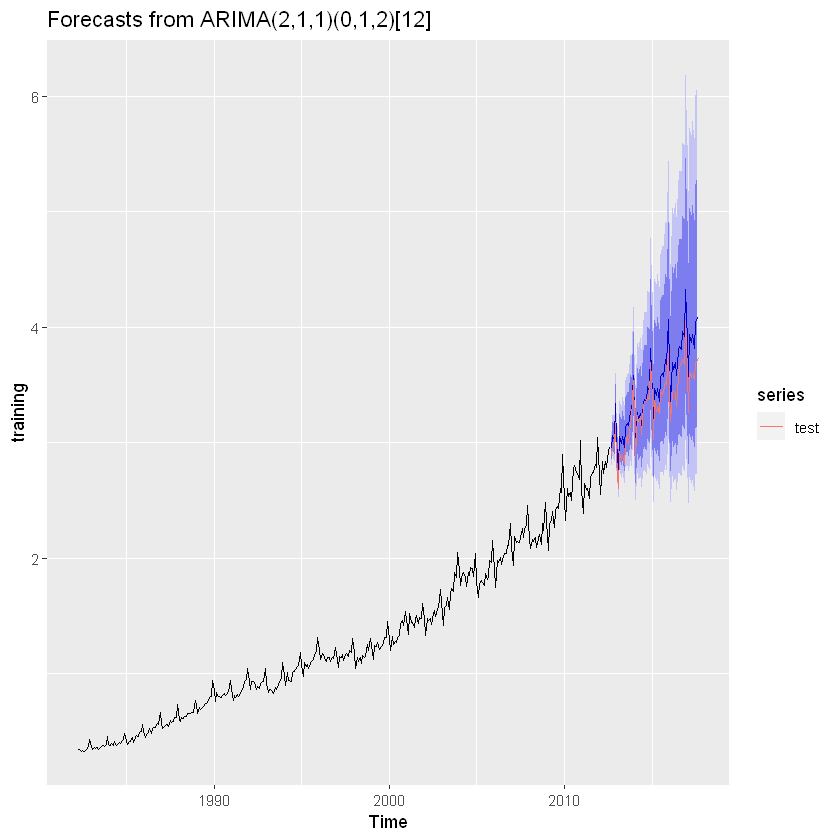

In [41]:
training <- subset(auscafe, end=length(auscafe)-61)
test <- subset(auscafe, start=length(auscafe)-60)

cafe.train <- Arima(training, order=c(2,1,1),
  seasonal=c(0,1,2), lambda=0)

cafe.train %>%
  forecast(h=60) %>%
  autoplot() + autolayer(test)

`fitted()` 함수에는 학습 데이터에 대해  $
h$
  단계 “적합값(fitted value)”을 허용하는 h라는 입력값이 있습니다. 이전 절에서 다룬 호주 외식 지출 데이터를 다루었습니다. 여기에서 모델에 사용된 학습 데이터가 있습니다. 이 학습 데이터에 대한 12 단계 앞 예측값을 그래프로 나타냈습니다. 모델에 계절성 차분(시차 12)와 1차 차분(시차 1) 둘 다 있기 때문에, 처음 몇 개의 관측값에 대해 예측값을 계산할 수 없습니다.

Warning message:
"Removed 25 rows containing missing values (`geom_line()`)."


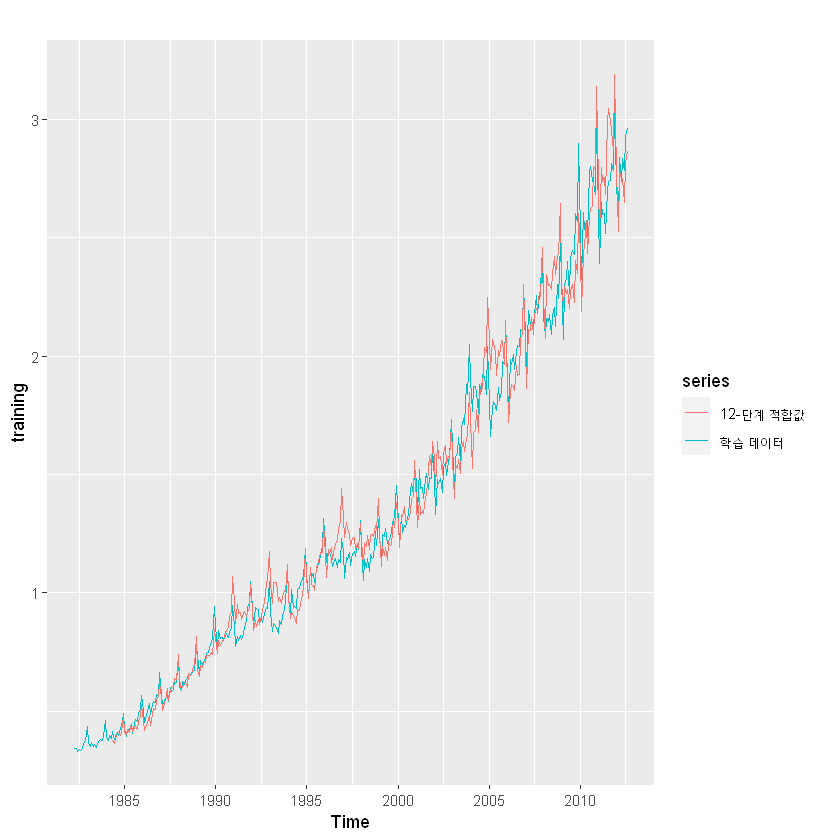

In [42]:
autoplot(training, series="학습 데이터") +
  autolayer(fitted(cafe.train, h=12),
    series="12-단계 적합값")

<br>

### 테스트 데이터에 대한 한 단계 예측값

학습 데이터를 가지고 모델을 맞춘 후에 테스트 데이터로 성능을 평가하는 것은 흔한 일입니다. 보통 이렇게 하는 방식에는 테스트 데이터에 대해 비교할 때 다른 예측 수평선을 사용한다는 의미가 담겨 있습니다. 위의 예제에서는, 테스트 데이터로 마지막 60개 관측값을 사용하고, 학습 데이터에 대한 예측 모델을 평가했습니다. 그러면 예측 오차들은 1-단계, 2-단계, …, 60-단계 앞이 될 것입니다. 예측 분산은 보통 예측 수평선에 따라 증가합니다. 따라서 테스트 데이터에서 단순하게 절대값을 취하는 오차나 제곱근 오차를 평균한다면, 이는 서로 다른 여러 분산값을 조합하는 결과가 됩니다.

이러한 문제를 해결하는 방법 중에 하나는 테스트 데이터에 대해 1-단계 오차를 구하는 것입니다. 즉, 어떤 매개변수를 추정하기 위해 학습 데이터를 계속 사용합니다만, 테스트 데이터로 예측값을 계산할 때, 각각의 (학습 데이터와 테스트 데이터) 관측값 이전의 모든 데이터를 사용합니다. 그래서 시간 $1,2,\dots,T-20$에 대한 학습 데이터는 입니다. 이러한 데이터에 대한 모델을 추정합니다만, $h=1,\dots,T-1$에 대해  $\hat{y}_{T-60+h|T-61+h}$을 계산합니다. 매개변수값을 추정하는데 테스트 데이터를 사용하지 않았기 때문에, 여전히 “타당한(fair)” 예측값이라고 볼 수 있겠습니다. `ets()`, `Arima()`, `tbats()`, `nnetar()` 등의 함수에서, `model` 입력값을 사용하여 이러한 계산을 쉽게 할 수 있습니다.

이제 위에서 사용한 것과 같은 ARIMA 모델을 사용하여, 모델을 테스트 데이터에 적용해보겠습니다.



In [43]:
cafe.test <- Arima(test, model=cafe.train)

accuracy(cafe.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.002622226,0.04591291,0.03412845,-0.07300775,1.002202,0.1898996,-0.05704137


이 경우에 `Arima()`가 다시 추정하지 않는다는 것에 주의하시길 바랍니다. 대신에, 이전에 얻은 (그리고 `cafe.train`으로 저장된) 모델을 테스트 데이터에 적용합니다. 다시 추정해서 얻은 모델이 아니기 때문에, 여기에서 얻은 “잔차(residual)”는 실제로 한 단계 예측오차입니다. 결과적으로, `accuracy()` 명령으로 얻은 결과는 (결과에서 “학습 데이터”라고 부르긴 하지만) 실제로 테스트 데이터입니다.



<br>

## 12.09. 결측값과 이상값 다루기

실제 데이터에서는 값이 없는 경우(결측값; missing value), 이상한 관측값(이상값; outlier), 그리고 다른 지저분한 특징이 종종 나타납니다. 이러한 것을 다루는 일은 골칫거리가 될 수 있습니다.

<br>

### 결측값

여러 이유로 데이터가 빠질 수 있습니다. 이렇게 데이터가 빠진 것 때문에 예측 모델에서 편향이 생길 것인지 여부를 고려해보는 것은 가치가 있습니다. 예를 들어, 어떤 상점의 판매량 데이터를 다루고 있는 상황을 생각해봅시다. 상점이 닫는 공휴일에는 값이 나타나지 않을 것입니다. 그리고 다음 날에는 결과적으로 판매량이 늘어날 수 있습니다. 예측 모델에서 이러한 효과를 고려하지 못한다면, 공휴일 다음 첫 날의 판매량을 낮게 추정하거나 높게 추정하게 될 것입니다. 어떤 날이 공휴일인지 공휴일 다음 날인지 나타내는 가변수(dummy variable)를 포함하는 동적회귀(dynamic regression) 모델은, 이러한 상황을 다훌 수 있는 한 가지 선택지가 될 수 있습니다. 어떠한 자동화된 기법도 이렇게 특정한 맥락에 의존하는 효과를 다룰 수 없습니다.

다른 상황에서는, 값이 빠지는 상황이 무작위로 일어날 수 있습니다. 예를 들면, 어떤 사람이 판매량을 기록하는 것을 깜빡할 수도 있고, 데이터를 기록하는 장치가 오작동할 수도 있습니다. 빠진 데이터의 타이밍이 예측 문제를 푸는데 특별한 정보를 주지 못하는 경우에는, 이렇게 빠진 값을 더 쉽게 다룰 수도 있습니다.

어떤 기법은 빠진 값을 별 문제 없이 다룹니다. 예를 들면, 단순 예측 기법(naïve forecasting method)은 가장 최근 값만 있다면 미래 시기에 대한 예측값을 낼 수 있습니다. 비슷하게, 과거 데이터에 빠진 값이 있을 때 3.1 절에서 소개한 다른 벤치마크 기법도 모두 예측값을 낼 것입니다. R에 있는 ARIMA 모델, 동적 회귀 모델, NNAR 모델 역시 작동 오류 없이 작동할 것입니다. 하지만, `ets()`, `stlf()`, `tbats()` 등을 포함하여 다른 모델링 함수는 빠진 값이 있을 때 처리하지 못합니다.

빠진 값 때문에 작동 오류가 생길 때는, 문제를 해결할 수 있는 방법이 적어도 2가지 있습니다. 첫 번째 방법은, 의미 있는 예측값을 내기 위해 충분히 많은 관측값이 준비되어 있다고 가정하고, 데이터 전체 중에서 가장 마지막으로 빠진 값 다음부터 사용하는 것입니다. 두 번째 방법은, 빠진 값을 추정하여 채워넣는 것입니다. na.interp() 함수는 빠진 값을 추정하여 채울 수 있게 해줍니다.

gold 데이터에는 1985년 1월 1일부터 1989년 3월 31일까지 매일 아침 금 가격이 있습니다. 이 시계열은 저자가 참여했던 컨설팅 프로젝트에서 제공 받은 것입니다. 여기에는 34개의 빠진 값이 있고 1개의 분명히 잘못된 값도 있습니다. 아래 그림은 빠진 관측값의 추정값을 빨간색으로 나타냅니다.



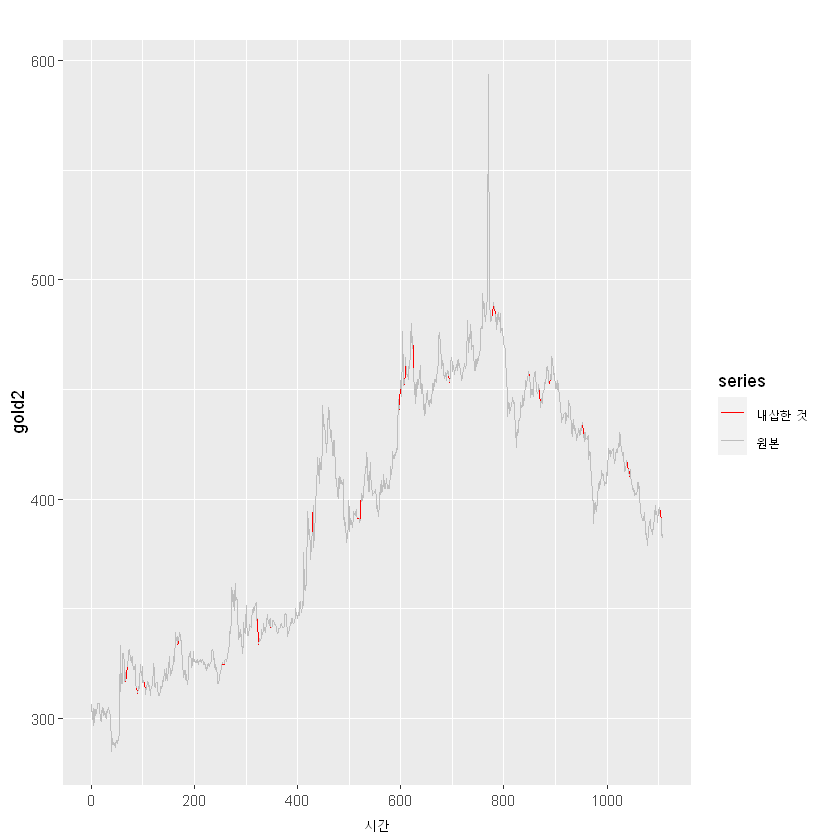

In [44]:
gold2 <- na.interp(gold)

autoplot(gold2, series="내삽한 것") +
  autolayer(gold, series="원본") +
  scale_colour_manual(
    values=c(`내삽한 것`="red",`원본`="gray")) +
  xlab("시간")

이 데이터와 같이 계절성이 없는 데이터의 경우에는, 단순하게 선형 내삽(Linear interpolation)으로 빠진 부분을 채웁니다. 계절성이 있는 데이터의 경우에는, 계절성 성분을 추정하기 위해 STL 분해를 사용하고, 계절성으로 조정된 시계열을 선형 내삽합니다. `imputeTS` 패키지에서 더 세련된 방식으로 빠진 값을 채우는 내삽 방법을 제공합니다.

<br>

### 이상값

이상값(outlier)들은 시계열에 있는 대부분의 관측값과는 다른 관측값입니다. 이러한 값은 오류일 수도 있고, 그냥 아주 특이한 것일 수도 있습니다. 이 책에서 다룬 모든 기법은 데이터에 극단적인 이상값이 있을 때 잘 작동하지 않습니다. 이 경우에, 이상값을 빠진값으로 처리하고 싶을 수도 있고, 데이터에 나타나는 대부분의 관측값과 더 일관적이도록 추정하고 싶을 수 있습니다.

이상값이 왜 나타나는지 생각하지 않고 단순히 이상값을 바꾸는 것은 위험합니다. 이상값을 통해 예측할 때 고려해야하는 유용한 정보(데이터를 생성하는 과정에 관한)를 얻을 수도 있습니다.

하지만, 이상값이 정말로 오류이거나 예측하려는 기간에 나타나지 않을 것이라고 가정한다면, 이러한 이상값을 바꾸는 것을 통해 예측 작업이 쉬워질 수 있습니다.

`tsoutliers()` 함수는 이상값을 잡아내도록 그리고 가능한 대체 값을 제시하도록 작성되었습니다. 그림에 나타난 `gold` 데이터에서 770일은 분명히 이상값입니다.



In [45]:
tsoutliers(gold)

$index
[1] 770

$replacements
[1] 494.9

더 자세히 살펴보면 주변 관측값은 분명한 이상값과는 달리 100 달러에 가깝게 나타납니다.



In [46]:
gold[768:772]

[1] 495.00 502.75 593.70 487.05 487.75

대부분 이것은 옮겨적는 과정에서 나타난 오류이고, 493.70 달러가 되어야 맞습니다.

또 하나의 유용한 함수는 `tsclean()`입니다. `tsclean()`은 이상값을 잡아내고 바꿔주며, 빠진 값으로도 바꿔줍니다. 이 함수는 정말 조심스럽게 사용해야합니다. 이 함수를 사용하면 빠진값을 다루지 못하거나 이상값에 예민하게 반응하는 예측 모델을 사용할 수 있도록 해줍니다. 예를 들면, `tsclean()`을 적용한 다음, ets() 함수를 gold 시계열에 사용할 수 있습니다.

여기에서는 이상값과 빠진값을 추정값으로 대체하였습니다.

